In [46]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys

sys.path.append('../src/models/')
import pysheaf as ps 
"""Note that this "import" is not from the python env, it is from the pysheaf.py in '../src/models/' """


In [14]:
def compare_vector_lists(list1, list2):
    if len(list1) != len(list2):
        return 0

    # Create a copy of list2
    remaining_vectors = list2[:]

    for vector1 in list1:
        found = 0

        for vector2 in remaining_vectors:
            if vector1 == vector2:
                found = 1
                remaining_vectors.remove(vector2)
                break

        if not found:
            return 0

    return 1

# Example usage:
list1 = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
list2 = [[7, 8, 9], [1, 2, 3], [4, 0, 6]]
compare_vector_lists(list1, list2)



def find_vector_index(vectors, p):
    # vectors has form of [[1, 2, 3], [4, 6]] (list of vectors) format, and p has form [[1, 2, 3], [4, 5]]
    index_set = []
    for k in range(len(p)):
        index = []
        for i, vector in enumerate(vectors):
            for j in p[k]:
                if j in vector:
                    index.append(i)
        index_set.append(index)
    return index_set
# Example usage:
vectors = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
p = [[1, 4, 9], [2, 6]]
result = find_vector_index(vectors, p) # the result of this is [[0, 1, 2], [0, 1]] 

def categorize_dictionary(dictionary):
    categories = []

    for key, lst in dictionary.items():
        found = False

        for category in categories:
            if compare_vector_lists(lst, category[0][1]):
                category.append((key, lst))
                found = True
                break

        if not found:
            categories.append([(key, lst)])
    cat_keys = []
    for category in categories:
        keys = []
        for key, _ in category:
            keys.append(key)
        cat_keys.append(keys)

    return cat_keys

# Example usage:
dictionary = {
    1: [[1, 2, 3], [4, 5, 6], [7, 8, 9]],
    2: [[7, 8, 9], [1, 2, 3], [4, 5, 6]],
    3: [[4, 5, 6], [1, 2, 3], [7, 8, 9]],
    4: [[10, 11, 12], [13, 14, 15]],
    5: [[7, 8, 9], [1, 2, 3], [4, 5, 6]],
    6: [[16, 17, 18], [19, 20, 21]],
    7: [[13, 14, 15], [10, 11, 12]]
}

result = categorize_dictionary(dictionary) # the result is [[1, 2, 3, 5], [4, 7], [6]]



In [3]:
def findPaths(G,u,n):
    #u: source node.  n: path length
    if n==0:
        return [[u]]
    paths = []
    for neighbor in G.neighbors(u):
        for path in findPaths(G,neighbor,n-1):
            if u not in path:
                paths.append([u]+path)
    return paths

def node_path_lengths_set(G):
    #G is a nx.graph, can compute either from G=nx.Graph or G=nx.from_numpy_matrix(A) where A is adjacency matrix
    """this returns the list of aggregated nodes by the function hash(num_of_all_paths_of_length_n, previous color)
    """
    node_path_lengths = {}
    for i in range(1, len(G) + 1):
        num_of_paths = []
        for j in range(len(G)):
            num = len(findPaths(G, i, j))
            num_of_paths.append(num)  
        node_path_lengths[i] = num_of_paths
    node_path_lengths = [list(node_path_lengths[i]) for i in range(1, len(node_path_lengths) + 1)]
    return node_path_lengths
      
def all_path_length_poset(G):
    #G is a nx.graph, can compute either from G=nx.Graph or G=nx.from_numpy_matrix(A) where A is adjacency matrix
    """this returns the list of aggregated nodes by the hash(num_of_all_paths, previous color)
    """ 
    p = np.array(node_path_lengths_set(G)).T
    class_set = {}
    d_1 = []
    for j in list(set(p[0])):
        t = [i + 1 for i, n in enumerate(p[0]) if n == j]
        d_1.append(t)
    class_set[0] = d_1
    for k in range(1, len(G._node)):
        d = []
        num_previous_class = len(class_set[k - 1])  
        for i in range(num_previous_class):
            new_class_index = class_set[k - 1][i]  #pick the class nodes to be refined
            new_class = [ p[k][v - 1] for v in new_class_index ]  #cat the corresponding labels
            for j in list(set(new_class)):
                #refine the previous class by the number of paths of length k
                t = [new_class_index[i] for i, n in enumerate(new_class) 
                     if n == j] #bin the same labels, i.e., refine the class by num_paths
                
                # refine the class by the colors of paths of length k
                pathset = {}
                previous_color_set = {}
                for m in t:
                    pathset[m] = findPaths(G, m, k)
                    previous_color = find_vector_index(class_set[k - 1], pathset[m])
                    previous_color_set[m] = previous_color
                
                #t: contains the nodes of the currrent class,
                #pathset: contains the paths of current class of length k
                #previous_color_set: contains the colors of the paths labeled in the previous color set
                
                refined_by_color = categorize_dictionary(previous_color_set)
                for q in range(len(refined_by_color)):
                    d.append(refined_by_color[q])
                
        class_set[k] = d
        if class_set[k] == class_set[k - 1]:
            class_set.popitem()
            break
            
    return class_set
    
        

## The following is an example of useage of pysheaf

In [4]:
## From p. 98 Example 4.9:

## Restriction Maps:
restAD = np.matrix([1,0,0,0])
restAG = np.matrix([0,0,1,-1])
restBD = np.matrix([1,0,0])
restBE = np.matrix([[0,0,3],[0,2,0]])
restBF = np.matrix([0,1,0])
restCE = np.matrix([[0,0,3,0],[0,0,0,2]])
restCF = np.matrix([0,0,0,1])
restCG = np.matrix([1,-1,0,0])

#note the SheafCoface(index, orientation, restriction)
#here the index is labeled on the edges, not on nodes

cofaceAD = ps.SheafCoface(3,1,restAD)
cofaceAG = ps.SheafCoface(6,1,restAG)
cofaceBD = ps.SheafCoface(3,-1,restBD)
cofaceBE = ps.SheafCoface(4,1,restBE)
cofaceBF = ps.SheafCoface(5,1,restBF)
cofaceCE = ps.SheafCoface(4,-1,restCE)
cofaceCF = ps.SheafCoface(5,-1,restCF)
cofaceCG = ps.SheafCoface(6,-1,restCG)

cellA = ps.SheafCell(dimension=0,stalkDim=4,
                     cofaces=[cofaceAD,cofaceAG])
cellB = ps.SheafCell(dimension=0,stalkDim=3,
                     cofaces=[cofaceBD,cofaceBE,cofaceBF])
cellC = ps.SheafCell(dimension=0,stalkDim=4,
                     cofaces=[cofaceCE,cofaceCF,cofaceCG])
cellD = ps.SheafCell(dimension=1,stalkDim=1)
cellE = ps.SheafCell(dimension=1,stalkDim=2)
cellF = ps.SheafCell(dimension=1,stalkDim=1)
cellG = ps.SheafCell(dimension=1,stalkDim=1)

sheaf = ps.Sheaf([cellA,cellB,cellC,cellD,cellE,cellF,cellG])

In [5]:
print(isinstance(cofaceAD,ps.SheafCoface))

True


In [6]:
sheaf.coboundary(0)

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  3.+0.j,
         0.+0.j,  0.+0.j, -3.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  2.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j, -2.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        -1.+0.j,  1.+0.j,  0.+0.j,  0.+0.j]])

In [7]:
sheaf.betti(0)

7

## Now the sheaf defined on our posets

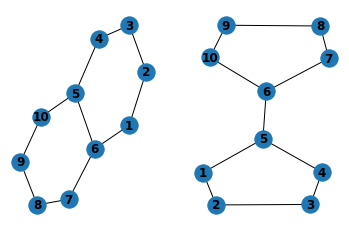

In [8]:
alpha = nx.Graph()
beta = nx.Graph()

alpha.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1), (6, 7), (7, 8), (8, 9), (9, 10), (10, 5)])
beta.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 1), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 6)])
subax1 = plt.subplot(121)
nx.draw(alpha, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw(beta, with_labels=True, font_weight='bold')

In [9]:
all_path_length_poset(alpha)

{0: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]],
 1: [[1, 2, 3, 4, 7, 8, 9, 10], [5, 6]],
 2: [[2, 3, 8, 9], [1, 4, 7, 10], [5, 6]]}

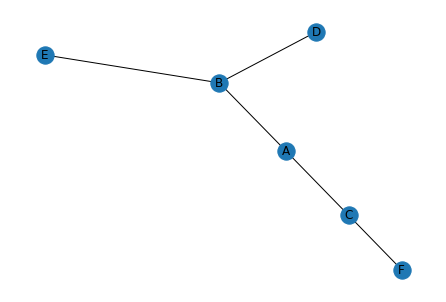

In [10]:
G = nx.Graph()
# Add nodes and edges
edges = [['A', 'B'], ['A', 'C'], ['B', 'D'], ['B', 'E'], ['C', 'F']]
G.add_edges_from(edges)
pos = nx.spring_layout(G)
"""nx.draw_networkx_edge_labels(
    G, pos, 
    edge_labels={('A', 'B'): 'AB', 
                 ('A', 'C'): 'AC', 
                 ('B', 'D'): 'BD',
                 ('B', 'E'): 'BE',
                 ('C', 'F'): 'CF'},
    font_color='red'
)
"""


nx.draw(G, pos, with_labels = True)

In [38]:
# Restriction maps
restAB=np.block([[np.eye(4), np.zeros((4, 6))], [np.zeros((4, 6)), np.eye(4)]])
restAC=np.block([[np.zeros((2, 4)), np.eye(2), np.zeros((2, 4))]])
restBD=np.block([[np.zeros((2, 1)), np.eye(2), np.zeros((2, 5))],[np.zeros((2, 5)), np.eye(2), np.zeros((2,1))]])
restBE=np.block([[np.eye(1),np.zeros((1,7))], [np.zeros((2, 3)), np.eye(2), np.zeros((2, 3))], 
               [np.zeros((1, 7)), np.eye(1)]])
restCF=np.eye(2)

In [39]:
restAB @ np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).T

array([ 1.,  2.,  3.,  4.,  7.,  8.,  9., 10.])

In [41]:
restAC @ np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).T

array([5., 6.])

In [42]:
restBD @ np.array([1, 2, 3, 4, 7, 8, 9, 10]).T

array([2., 3., 8., 9.])

In [43]:
restBE @ np.array([1, 2, 3, 4, 7, 8, 9, 10]).T

array([ 1.,  4.,  7., 10.])

In [45]:
#note the SheafCoface(index, orientation, restriction maps)! Here the "index" is the label of the edge, not the node

cofaceAB = ps.SheafCoface('AB', -1, restAB)
cofaceAC = ps.SheafCoface('AC', -1, restAC)
cofaceBD = ps.SheafCoface('BD', -1, restBD)
cofaceBE = ps.SheafCoface('BE', -1, restBE)
cofaceCF = ps.SheafCoface('CF', -1, restCF)

cellA = ps.SheafCell(dimension=0,stalkDim=10,
                     cofaces=[cofaceAD,cofaceAC])
cellB = ps.SheafCell(dimension=0,stalkDim=8,
                     cofaces=[cofaceBD,cofaceBE])
cellC = ps.SheafCell(dimension=0,stalkDim=2,
                     cofaces=[cofaceCF])
cellD = ps.SheafCell(dimension=0,stalkDim=4)
cellE = ps.SheafCell(dimension=0,stalkDim=4)
cellF = ps.SheafCell(dimension=0,stalkDim=2)

sheaf = ps.Sheaf([cellA,cellB,cellC,cellD,cellE,cellF])

In [35]:
sheaf.coboundary(0)

array([], shape=(0, 30), dtype=complex128)

In [36]:
sheaf.betti(0)

30

In [37]:
sheaf.cohomology(0) == np.eye(30)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,